# Microkinetic modelling of  multi-electron transfer electrocatalyis
$$\require{mhchem}$$

Author: 

Joel W. Ager (jwager@lbl.gov, [ORCID](https://orcid.org/0000-0001-9334-9751)) [Group website](http://ager.mse.berkeley.edu), [GitHub](https://github.com/joelager)

Jinghan Li (mseljh@sjtu.edu.cn, [ORCID](https://orcid.org/0000-0003-3619-5121))

Adapts analyses in 
>Koper, M. T. M.; Jansen, A. P. J.; van Santen, R. A.; Lukkien, J. J.; Hilbers, P. A. J. Monte Carlo Simulations of a Simple Model for the Electrocatalytic CO Oxidation on Platinum. [*J. Chem. Phys.* **1998**, 109, 6051–6062](http://aip.scitation.org/doi/10.1063/1.477230).

In this paper, a mean field model is compared to a lattice Monte Carlo simulation for a model reaction, CO stripping from Pt. In this notebook, the mean field model is coded.  

Koper and co-workers consider the two steps of CO oxidation on Pt: 

$$\ce{H2O + $*$  <=> OH_{ads} + H+ + e-}\tag{1}$$

$$\ce{CO_{ads} + OH_{ads}  -> CO2 + H+ + e- + 2$*$}\tag{2}$$

In their analysis, reaction (1) will be considered reversible but reaction (2) will be irreversible (i.e. there will not be a way to repopulate the surface with CO). 

Rate constants are:

$$k_1 = k^0_1 \exp(\alpha_1 e_0 E / k_B T) $$

$$k_{-1} = k^0_{-1} (-(1-\alpha_1) \exp(e_0 E / k_B T) $$

$$k_2  = k^0_2  \exp(\alpha  e_0 E / k_B T) $$

where $e_0$ is elementary charge and $E$ is the applied potential. Both transfer coefficients $\alpha$ will be set to 0.5. 

The reaction rates $v_i$ are:

$$v_1 = \Gamma_s k_1 (1-\theta_{OH} - \theta_{CO} ) $$

$$v_{-1} = \Gamma_s k_{-1} \theta_{OH}  $$

$$v_2  = \Gamma_s Z k  \theta_{OH}  \theta_{CO}  $$

where $\Gamma_s$ is the density of surface sites (cm<sup>-2</sup>) and $Z$ is the number of nearest neighbor sites, which is 4 on the square lattice used.  Total current density is:

$$ j = e_0 (v_1 - v_{-1} + v ) $$

The time evolution of the mean field coverages $\theta_{CO}$ and $\theta_{OH}$ are governed by two ODEs:

$$\Gamma_s \frac{d \theta_{OH}}{dt} = v_1-v_{-1} -v  $$
$$\Gamma_s \frac{d \theta_{CO}}{dt} = -v  $$

## 0 Initialize

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from units import *
# Importing the ODE solver
from scipy.integrate import solve_ivp   # new solver to use, odeint will be deprecated

In [2]:
# Constants to be used throughout the calcuation
T = 300*kelvin

α_1 = 0.5                    # Transfer coeffients
α_2 = 0.5

Z = 4.0                      # Number of nearest neighbors
Γ_sites = 1.32e15*cm**-2     # Density of surface atoms

## 1 Electrochemical model

In [3]:
# Two sets of parameters for FAST and SLOW mechanism
class EC_model_params():
    """
    Default is the FAST case from Koper paper
    """
    # For OH- adsorption and desorption
    k1zero=0.02*sec**-1 
    kminus1zero=1e4*sec**-1 
    # For the *CO + *OH -> CO2(g)
    k2zero=0.8234*sec**-1
    
case_FAST = EC_model_params()
case_SLOW = EC_model_params()
case_SLOW.k2zero = 0.8234e-5

In [4]:
# Rate constants
def k1(E, EC_model_params):   
    return EC_model_params.k1zero*np.exp( (α_1*q*E)/(kB*T) )

def kminus1(E, EC_model_params):   
    return EC_model_params.kminus1zero*np.exp( -((1-α_1)*q*E)/(kB*T) )

def k2(E, EC_model_params):   
    return EC_model_params.k2zero*np.exp( (α_1*q*E)/(kB*T) )

# Currents
def J(E, θ_OH, θ_CO, EC_model_params):
    v_1 = k1 (E, EC_model_params)*(1 - θ_OH - θ_CO)
    v_minus1 = kminus1 (E, EC_model_params)*θ_OH
    v_2  = Z*k2(E, EC_model_params)*θ_OH*θ_CO
    return (q*Γ_sites)*(v_1 - v_minus1 + v_2 )

## 2 CV scan function
In Fig. 1 of paper, scan goes from 0.1 to 0.5 V and back again.  

In [5]:
# Function to construct a single CV scan
def E_CV(t):
    potential = np.piecewise(t, 
                             [t < 0 , 
                              t >= 0 and t < cycle_time/2.0, 
                              t > cycle_time/2. and t < cycle_time ,
                              t >= cycle_time], 
                             [Estart, 
                              Estart + t*sweep_rate, 
                              Efinish - (t - cycle_time/2.0) *sweep_rate,
                              Estart])
    return potential.item(0)

In [6]:
# Sweep parameters for Koper Figure 1
Estart =  0.1 *volt              # E = 0.3 was largest driving force in Figure 1
Efinish = 0.5 *volt              # Larger driving forces lead to huge currents. 
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish - Estart)/sweep_rate 

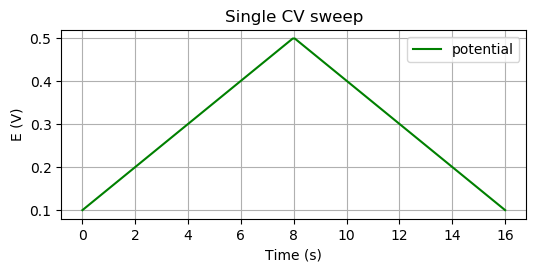

In [7]:
# Checking the CV sweep
t_plot = np.linspace(0,cycle_time,200)
plt.figure(figsize=(6,2.5), dpi=100)
plt.title('Single CV sweep')
plt.plot(t_plot, [E_CV(t) for t in t_plot], 'g', label = "potential") 
plt.xlabel("Time (s)")
plt.ylabel("E (V)")
plt.legend(loc='best')
plt.grid()
plt.savefig(('CV sweep.png'),dpi=600,format='png')

## 3 ODEs and solution

In [8]:
# Sets up the function to be called by solve_ivp

def CV_scan_ODEs(t,z,EC_model_params):
    θ_OH = z[0]
    θ_CO = z[1]
    
    dθ_OHdt = k1(E_CV(t), EC_model_params)*(1 - θ_OH - θ_CO) - \
              kminus1(E_CV(t), EC_model_params)*θ_OH - \
              Z*k2(E_CV(t), EC_model_params)*θ_OH*θ_CO
    
    dθ_COdt = -Z*k2(E_CV(t),EC_model_params)*θ_OH*θ_CO
    dzdt = [dθ_OHdt, dθ_COdt]
    return dzdt

def fixed_E_ODEs(t, z, E, EC_model_params):
    θ_OH = z[0]
    θ_CO = z[1]
    
    dθ_OHdt = k1(E, EC_model_params)*(1 - θ_OH- θ_CO) - \
              kminus1(E, EC_model_params)*θ_OH - \
              Z*k2(E, EC_model_params)*θ_OH*θ_CO
    
    dθ_COdt = -Z*k2(E, EC_model_params)*θ_OH*θ_CO
    dzdt = [dθ_OHdt, dθ_COdt]
    return dzdt

# 4 CV sweeps (Figures 1)

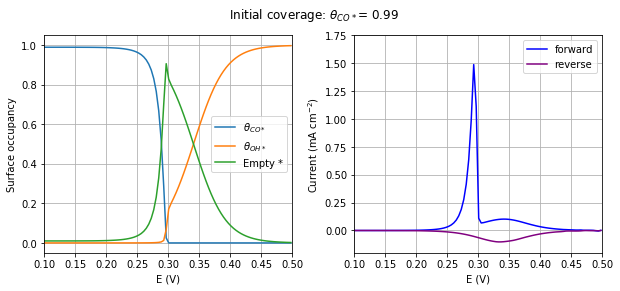

In [9]:

# time points for ODE integration
t_CV = np.linspace(0, cycle_time, 200)

# Intial conditions ########################### Remember to change for different initial coverage and rate mechanism #####################
case = case_FAST
# case = case_SLOW

θ_OH_init = 0.00

θ_CO_init = 0.99
# θ_CO_init = 0.75        
# θ_CO_init = 0.50        
############################################## Remember to change for different initial coverage and rate mechanism ######################

# Note use of {{}} to fix issue with parsing the title string     
Title = 'Initial coverage: $θ_{{CO*}}$= {}'.format(θ_CO_init)

# solve ODE
sol_CV_2 = solve_ivp(lambda t,y: CV_scan_ODEs(t,y,case), 
                     [0, cycle_time], 
                     [θ_OH_init, θ_CO_init], 
                     t_eval=t_CV, 
                     method='Radau')
θ_OH_2 = sol_CV_2.y[0]
θ_CO_2 = sol_CV_2.y[1]

# Compute the E values for the CV plot 
E_CV_plot = np.array([E_CV(t) for t in t_CV])

# Compute Current densities for the plot - loop for the moment
J_CV_plot_2 = np.empty_like(t_CV)
for i, (E,θ_OH, θ_CO) in enumerate(zip(E_CV_plot, θ_OH_2, θ_CO_2)):
    J_CV_plot_2[i] = J(E, θ_OH, θ_CO, case_FAST)

    
# Display the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle(Title)

# LH figure
# for forward & backward
# ax1.plot(E_CV_plot, θ_OH_2, 'g', label = "*OH") 
# ax1.plot(E_CV_plot, θ_CO_2, 'r', label = "*CO")
# ax1.plot(E_CV_plot, 1-θ_CO_2-θ_OH_2, label = "Empty *")

# for only forward
ax1.plot(np.split(E_CV_plot,2)[0], np.split(θ_CO_2,2)[0], label = "$θ_{CO*}$")
ax1.plot(np.split(E_CV_plot,2)[0], np.split(θ_OH_2,2)[0], label = "$θ_{OH*}$") 
ax1.plot(np.split(E_CV_plot,2)[0], np.split(1-θ_CO_2-θ_OH_2,2)[0], label = "Empty *")

ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("E (V)")
ax1.set_xlim(Estart,Efinish)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)

# RH figure
ax2.plot(np.split(E_CV_plot,2)[0], np.split(J_CV_plot_2,2)[0]/(mA*cm**-2),'blue', label='forward')
ax2.plot(np.split(E_CV_plot,2)[1], np.split(J_CV_plot_2,2)[1]/(mA*cm**-2),'purple', label='reverse')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("E (V)")
ax2.set_xlim(Estart,Efinish)
ax2.set_ylabel("Current (mA cm$^{-2}$)")
ax2.set_ylim(-0.2,1.75)######################## Remember to change for different coverage #####################
# ax2.set_ylim(-0.15,0.55)
# ax2.set_ylim(-0.15,0.35)
############################################## Remember to change for different coverage ######################

fig.subplots_adjust(wspace=0.25)

# Save the data and plot
E = E_CV_plot.reshape (200,1)
θ_CO = θ_CO_2.reshape (200,1)
θ_OH = θ_OH_2.reshape (200,1)
Current = J_CV_plot_2.reshape (200,1)
temp = np.hstack([E,θ_CO,θ_OH,1-θ_OH-θ_CO,Current/(mA*cm**-2)]) # merge the 2 arrays
df = pd.DataFrame(temp)
df.rename(columns={0: 'E', 1: 'CO*', 2: 'OH*', 3:'Empty *', 4: 'Current'},inplace=True)

df.to_csv('CV cuverage & current {}.csv'.format(θ_CO_init))
plt.savefig(('CV cuverage & current {}.png'.format(θ_CO_init)),dpi=600,format='png')

# 5 Potential step (Figure 5)

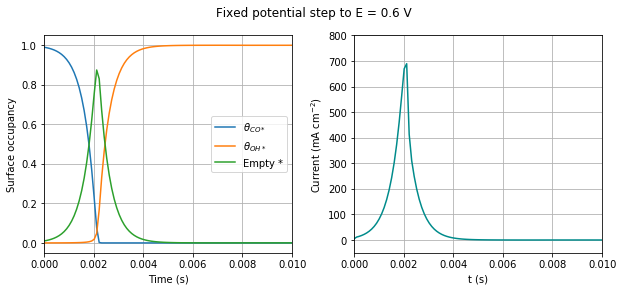

In [10]:
############################################## Remember to change for different potential ######################
case = case_FAST
# case = case_SLOW

t_final = 0.01
# t_final = 0.05
# t_final = 3
# t_final = 1000

E = 0.6
# E = 0.5
# E = 0.275
# E = 0.14
############################################## Remember to change for different potential ######################

t_span = np.linspace(0.0, t_final, 100)
sol = solve_ivp(lambda t,y: fixed_E_ODEs(t,y ,E, case),
                [0,t_final], 
                [0.00, 0.99],  # initial coverage here: OH = 0.0 CO = 0.99
                t_eval=t_span, 
                method='LSODA')
θ_OH_sol = sol.y[0]
θ_CO_sol = sol.y[1]

# Current density
J_Estep_plot = np.empty_like(t_span)
for i, (θ_OH, θ_CO) in enumerate(zip(θ_OH_sol, θ_CO_sol)):
    J_Estep_plot[i] = J(E, θ_OH, θ_CO, case_FAST)

# Display the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
fig.suptitle('Fixed potential step to E = {} V'.format(E))  
# LH figure
ax1.plot(t_span, θ_CO_sol, label = "$θ_{CO*}$")
ax1.plot(t_span, θ_OH_sol, label = "$θ_{OH*}$") 
ax1.plot(t_span, 1-θ_CO_sol-θ_OH_sol, label = "Empty *") 

ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("Time (s)")
ax1.set_xlim(0, t_final)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)

# RH figure
ax2.plot(t_span, J_Estep_plot/(mA*cm**-2),'darkcyan')
ax2.grid(True)
ax2.set_xlabel("t (s)")
ax2.set_xlim(0, t_final)
ax2.set_ylabel("Current (mA cm$^{-2}$)")
############################################## Remember to change for different potential ######################
ax2.set_ylim(-50, 800)
# ax2.set_ylim(-10, 120)
# ax2.set_ylim(-0.2, 1.1)
# ax2.set_ylim(-0.0002, 0.0025)
############################################## Remember to change for different potential ######################
fig.subplots_adjust(wspace=0.25)

# Save the data and plot
time = t_span.reshape (100,1)
θ_CO = θ_CO_sol.reshape (100,1)
θ_OH = θ_OH_sol.reshape (100,1)
Current = J_Estep_plot.reshape (100,1)
temp = np.hstack([time,θ_CO,θ_OH,1-θ_OH-θ_CO,Current/(mA*cm**-2)])
df = pd.DataFrame(temp)
df.rename(columns={0: 'time', 1: 'CO*', 2: 'OH*', 3:'Empty *', 4: 'Current'},inplace=True)

df.to_csv('Potential step cuverage & current {}.csv'.format(E))
plt.savefig(('Potential step cuverage & current {}.png'.format(E)),dpi=600,format='png')